# pix2pix: Image-to-image translation with a conditional GAN

In [126]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.utils as vutils
import torchvision
from barbar import Bar
import os
from torchvision.models import resnet18
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

from torch.cuda.amp import autocast, GradScaler

In [127]:
base_dir = os.getcwd()
dataset_dir = os.path.abspath(os.path.join(base_dir, "..", "train"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

In [128]:
sample_image_path = os.path.join(dataset_dir, 'images', 'guatemala-volcano_00000013_post_disaster.png')

# Check if the file exists
if not os.path.exists(sample_image_path):
    print(f"File not found: {sample_image_path}")
else:
    # Load the sample image
    sample_image = torchvision.io.read_image(sample_image_path)
    print(sample_image.shape)

torch.Size([3, 1024, 1024])


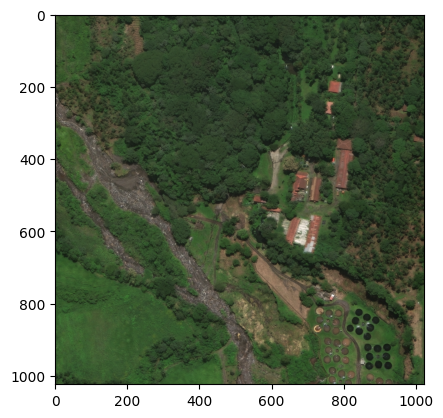

In [129]:
plt.figure()
plt.imshow(sample_image.permute(1, 2, 0).numpy())

Number of images in dataset: 2799
Pre-disaster image shape: torch.Size([1, 3, 256, 256])
Post-disaster image shape: torch.Size([1, 3, 256, 256])


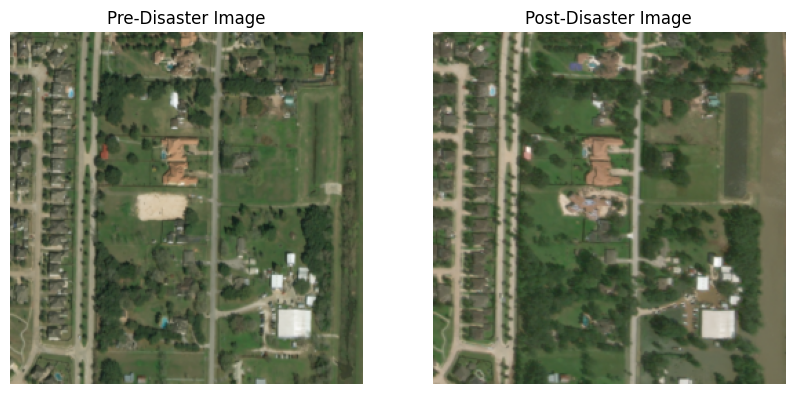

In [130]:
class DisasterDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = sorted(pathlib.Path(root_dir).rglob('*_pre_disaster.png'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        pre_image_path = self.images[idx]
        
        post_image_path = str(pre_image_path).replace('_pre_disaster', '_post_disaster')
        
        pre_image = Image.open(pre_image_path).convert("RGB")
        post_image = Image.open(post_image_path).convert("RGB")

        if self.transform:
            pre_image = self.transform(pre_image)
            post_image = self.transform(post_image)

        return pre_image, post_image
    
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

image_dir = os.path.join(dataset_dir, 'images')
dataset = DisasterDataset(image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

print(f"Number of images in dataset: {len(dataset)}")

pre_image, post_image = next(iter(dataloader))

print(f"Pre-disaster image shape: {pre_image.shape}")
print(f"Post-disaster image shape: {post_image.shape}")


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Pre-Disaster Image")
plt.imshow(pre_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # De-normalize for visualization
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Post-Disaster Image")
plt.imshow(post_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # De-normalize for visualization
plt.axis("off")
plt.show()

Creating a Test Dataset Loader

Pre-disaster image shape: torch.Size([1, 3, 512, 512])
Post-disaster image shape: torch.Size([1, 3, 512, 512])


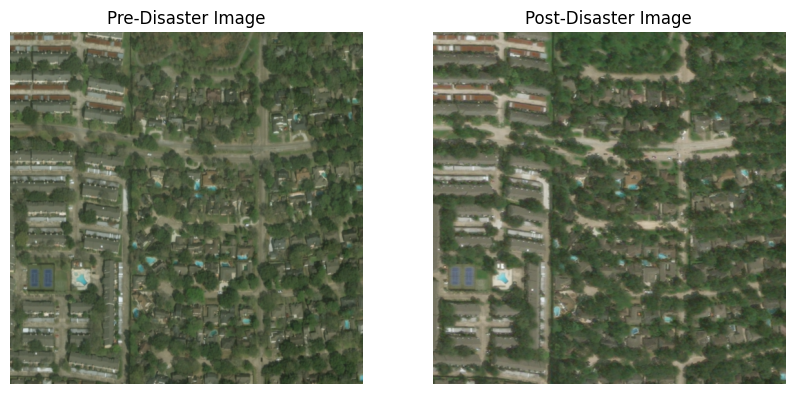

In [ ]:
test_dir = os.path.join("..", 'test')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

image_dir = os.path.join(dataset_dir, 'images')
test_dataset = DisasterDataset(image_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

pre_image, post_image = next(iter(test_dataloader))

print(f"Pre-disaster image shape: {pre_image.shape}")
print(f"Post-disaster image shape: {post_image.shape}")


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Pre-Disaster Image")
plt.imshow(pre_image[0].permute(1, 2, 0).numpy())  # De-normalize for visualization
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Post-Disaster Image")
plt.imshow(post_image[0].permute(1, 2, 0).numpy())  # De-normalize for visualization
plt.axis("off")
plt.show()

In [132]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [133]:
class Encoder(nn.Module):
    def __init__(self, z_dim=512):
        super(Encoder, self).__init__()
        self.z_dim = z_dim

        # Downsampling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)  # (batch_size, 64, 128, 128)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)  # (batch_size, 128, 64, 64)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)  # (batch_size, 256, 32, 32)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)  # (batch_size, 512, 16, 16)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv5 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False)  # (batch_size, 512, 8, 8)
        self.bn5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False)  # (batch_size, 512, 4, 4)
        self.bn6 = nn.BatchNorm2d(512)

        self.conv7 = nn.Conv2d(512, z_dim, kernel_size=4, stride=1, padding=0, bias=False)  # (batch_size, z_dim, 1, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn6(self.conv6(x)), negative_slope=0.2)
        x = self.conv7(x)
        return x

In [134]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_shape=(3, 256, 256)):
        super(Generator, self).__init__()
        channels, _, _ = img_shape
        self.layers = nn.Sequential(
            # Input: [B, z_dim, 1, 1] → [B, 512, 4, 4]
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            # → [B, 256, 8, 8]
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            # → [B, 128, 16, 16]
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            # → [B,  64, 32, 32]
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            # → [B,  32, 64, 64]
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            # → [B,  16,128,128]
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16), nn.ReLU(inplace=True),
            # → [B,   3,256,256]
            nn.ConvTranspose2d(16, channels, 4, 2, 1, bias=True),
            nn.Tanh()
        )

    def forward(self, z):
        return self.layers(z)

In [135]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=16):  # Reduced latent dimension
        super(Discriminator, self).__init__()

        # Inference over images (pre and post)
        self.conv1_img = nn.Conv2d(3, 16, 4, stride=2, bias=False)
        self.conv2_img = nn.Conv2d(16, 32, 4, stride=2, bias=False)
        self.bn2_img = nn.BatchNorm2d(32)
        self.conv3_img = nn.Conv2d(32, 64, 4, stride=2, bias=False)
        self.bn3_img = nn.BatchNorm2d(64)
        self.conv4_img = nn.Conv2d(64, 128, 4, stride=2, bias=False)
        self.bn4_img = nn.BatchNorm2d(128)

        # Inference over latent codes (pre and post)
        self.conv1_latent = nn.Conv2d(z_dim, 128, 1, stride=1, bias=False)
        self.conv2_latent = nn.Conv2d(128, 128, 1, stride=1, bias=False)

        # Joint inference
        self.conv1_joint = nn.Conv2d(512, 256, 1, stride=1, bias=False)
        self.conv2_joint = nn.Conv2d(256, 128, 1, stride=1, bias=False)
        self.conv3_joint = nn.Conv2d(128, 1, 1, stride=1, bias=False)

    def inf_img(self, img):
        """Process image inputs (pre or post)."""
        x = F.leaky_relu(self.conv1_img(img), negative_slope=0.1)
        x = F.leaky_relu(self.bn2_img(self.conv2_img(x)), negative_slope=0.1)
        x = F.leaky_relu(self.bn3_img(self.conv3_img(x)), negative_slope=0.1)
        x = F.leaky_relu(self.bn4_img(self.conv4_img(x)), negative_slope=0.1)
        return x

    def inf_latent(self, latent, target_size):
        """Process latent code inputs (pre or post)."""
        z = F.leaky_relu(self.conv1_latent(latent), negative_slope=0.1)
        z = F.leaky_relu(self.conv2_latent(z), negative_slope=0.1)
        # Resize latent code to match the spatial dimensions of the image features
        z = F.interpolate(z, size=target_size, mode='bilinear', align_corners=False)
        return z

    def inf_joint(self, joint):
        """Process joint features from images and latent codes."""
        xz = F.leaky_relu(self.conv1_joint(joint), negative_slope=0.1)
        xz = F.leaky_relu(self.conv2_joint(xz), negative_slope=0.1)
        return self.conv3_joint(xz)

    def forward(self, pre_img, post_img, pre_latent, post_latent):
        # Process pre and post images
        pre_features = self.inf_img(pre_img)
        post_features = self.inf_img(post_img)

        # Process pre and post latent codes
        target_size = pre_features.shape[2:]  # Get spatial dimensions of pre_features
        pre_latent_features = self.inf_latent(pre_latent, target_size=target_size)
        post_latent_features = self.inf_latent(post_latent, target_size=target_size)


        # Concatenate all features
        joint_features = torch.cat(
            (pre_features, post_features, pre_latent_features, post_latent_features), dim=1
        )

        # Process joint features
        out = self.inf_joint(joint_features)

        return torch.sigmoid(out)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [136]:
class TrainerBiGAN:
    def __init__(self, args, data, device):
        self.args = args
        self.train_loader = data
        self.device = device
        self.writer = SummaryWriter(log_dir='./logs')
        self.checkpoint_dir = getattr(args, 'checkpoint_dir', './checkpoints')
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def train(self):
        """Training the BiGAN with 2 images and 2 latent codes"""
        self.G = Generator(self.args.latent_dim).to(self.device)
        self.E = Encoder(self.args.latent_dim).to(self.device)
        self.D = Discriminator(self.args.latent_dim).to(self.device)

        self.G.apply(weights_init_normal)
        self.E.apply(weights_init_normal)
        self.D.apply(weights_init_normal)

        optimizer_ge = optim.Adam(
            list(self.G.parameters()) + list(self.E.parameters()), lr=self.args.lr_adam
        )
        optimizer_d = optim.Adam(self.D.parameters(), lr=self.args.lr_adam)

        scaler = torch.amp.GradScaler(device='cuda')
        criterion = nn.BCELoss()
        
        
        start_epoch = 0
        if getattr(self.args, 'resume', None):
            ckpt_path = self.args.resume
            if os.path.isfile(ckpt_path):
                ckpt = torch.load(ckpt_path, map_location=self.device)
                self.G.load_state_dict(ckpt['G'])
                self.E.load_state_dict(ckpt['E'])
                self.D.load_state_dict(ckpt['D'])
                optimizer_ge.load_state_dict(ckpt['optimizer_ge'])
                optimizer_d.load_state_dict(ckpt['optimizer_d'])
                start_epoch = ckpt['epoch'] + 1
                print(f"Resumed from checkpoint '{ckpt_path}' at epoch {start_epoch}")

        criterion = nn.BCELoss()

        for epoch in range(start_epoch, self.args.num_epochs + 1):
            ge_losses = 0
            d_losses = 0
            
            ckpt = {
                 'epoch': epoch,
                 'G': self.G.state_dict(),
                 'E': self.E.state_dict(),
                 'D': self.D.state_dict(),
                 'optimizer_ge': optimizer_ge.state_dict(),
                 'optimizer_d': optimizer_d.state_dict(),
             }
            torch.save(ckpt, os.path.join(self.checkpoint_dir, f'ckpt_epoch{epoch}.pt'))

            for pre_image, post_image in Bar(self.train_loader):
                # Move data to device
                pre_image = pre_image.to(self.device)
                post_image = post_image.to(self.device)

                # Define real and fake labels
                y_real = Variable(torch.ones((pre_image.size(0), 1), device=self.device))
                y_fake = Variable(torch.zeros((pre_image.size(0), 1), device=self.device))

                # Add noise for stability
                noise_pre = Variable(torch.Tensor(pre_image.size()).normal_(0, 
                                  0.1 * (self.args.num_epochs - epoch) / self.args.num_epochs),
                                  requires_grad=False).to(self.device)
                noise_post = Variable(torch.Tensor(post_image.size()).normal_(0, 
                                  0.1 * (self.args.num_epochs - epoch) / self.args.num_epochs),
                                  requires_grad=False).to(self.device)

                # ---------------------
                # Train Discriminator
                # ---------------------
                optimizer_d.zero_grad()

                # Encode real images to latent codes

                # --- Discriminator step: detach E/G so D updates only D’s weights ---
                real_pre_latent = self.E(pre_image).detach()
                real_post_latent = self.E(post_image).detach()
                
                fake_pre_image = self.G(real_pre_latent).detach()
                fake_post_image = self.G(real_post_latent).detach()
                
                # Discriminator outputs
                real_output = self.D(pre_image + noise_pre, post_image + noise_post, real_pre_latent, real_post_latent)
                
                y_real = torch.ones_like(real_output, device=self.device)
                y_fake = torch.zeros_like(real_output, device=self.device)
                
                fake_output_1 = self.D(fake_pre_image, fake_post_image, real_pre_latent, real_post_latent)
                fake_output_2 = self.D(pre_image, fake_post_image, real_pre_latent, real_post_latent)
                fake_output_3 = self.D(fake_pre_image, post_image, real_pre_latent, real_post_latent)

                # Discriminator loss
                loss_d_real = criterion(real_output, y_real)
                loss_d_fake = (
                    criterion(fake_output_1, y_fake)
                    + criterion(fake_output_2, y_fake)
                    + criterion(fake_output_3, y_fake)
                ) / 3
                loss_d = loss_d_real + loss_d_fake

                # Backpropagation for discriminator
                scaler.scale(loss_d).backward()
                scaler.step(optimizer_d)
                scaler.update()

                # ---------------------
                # Train Generator + Encoder
                # ---------------------
                optimizer_ge.zero_grad()

                real_pre_latent = self.E(pre_image)
                real_post_latent = self.E(post_image)
                
                fake_pre_image = self.G(real_pre_latent)
                fake_post_image = self.G(real_post_latent)
 
                # Discriminator outputs for generator
                fake_output_1 = self.D(fake_pre_image, fake_post_image, real_pre_latent, real_post_latent)
                fake_output_2 = self.D(pre_image, fake_post_image, real_pre_latent, real_post_latent)
                fake_output_3 = self.D(fake_pre_image, post_image, real_pre_latent, real_post_latent)

                # Generator + Encoder loss
                loss_gan = (
                    criterion(fake_output_1, y_real)
                    + criterion(fake_output_2, y_real)
                    + criterion(fake_output_3, y_real)
                ) / 3
                
                # pixel‐wise L1 term
                l1_weight = getattr(self.args, 'l1_weight', 100)
                loss_l1  = F.l1_loss(fake_pre_image, pre_image) \
                         + F.l1_loss(fake_post_image, post_image)
                loss_ge = loss_gan + l1_weight * loss_l1

                # Backpropagation for generator + encoder
                loss_ge.backward()
                optimizer_ge.step()

                # Accumulate losses
                ge_losses += loss_ge.item()
                d_losses += loss_d.item()

            # Log losses to TensorBoard
            self.writer.add_scalar('Loss/Discriminator', d_losses / len(self.train_loader), epoch)
            self.writer.add_scalar('Loss/Generator', ge_losses / len(self.train_loader), epoch)

            # Save generated images every 50 epochs
            if epoch % 50 == 0:
                with torch.no_grad():
                    fixed_pre_latent = self.E(pre_image)
                    fixed_post_latent = self.E(post_image)
                    fixed_fake_pre_image = self.G(fixed_pre_latent)
                    fixed_fake_post_image = self.G(fixed_post_latent)
                    vutils.save_image(
                        torch.cat([fixed_fake_pre_image, fixed_fake_post_image], dim=0),
                        f'../output/epoch_{epoch}_generated.png',
                        normalize=True,
                    )
                    
                    inputs = torch.cat([pre_image, post_image], dim=0)
                    vutils.save_image(
                        inputs,
                        f'../output/epoch_{epoch}_inputs.png',
                        normalize=True,
                    )

            # Print progress
            print(
                f"Epoch [{epoch}/{self.args.num_epochs}] "
                f"Discriminator Loss: {d_losses / len(self.train_loader):.4f}, "
                f"Generator Loss: {ge_losses / len(self.train_loader):.4f}"
            )

        self.writer.close()

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

Launch the TensorBoard viewer (Sorry, this doesn't
display on tensorflow.org):

Finally, run the training loop:

In [137]:
print(device)
%ls

cuda
/bin/bash: /home/khois345/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 bigan-pix2pix.ipynb*  'pix2pix_updated - new.ipynb'*
 checkpoints/          'pix2pix_updated - old with original discrim.ipynb'*
 gan_training.py*      'pix2pix_updated old not working.ipynb'*
 logs/                  pix2pix_updated.ipynb*
 model.png*             temp/
 output/                training_checkpoints/
 pix2pix_bigan.ipynb*  'training_checkpoints - maybe working latest'/


In [138]:
log_dir="logs/"

%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 434410), started 2 days, 8:26:44 ago. (Use '!kill 434410' to kill it.)

In [ ]:
num_epochs = 600
lr_adam = 1e-4
batch_size = 1
latent_dim = 512
LAMBDA = 100
resume = os.path.join(base_dir, 'checkpoints', 'ckpt_epoch0.pt')  

class Args:
    def __init__(self):
        self.num_epochs = num_epochs
        self.lr_adam = lr_adam
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.resume = resume
        self.l1_weight = LAMBDA

# Instantiate the Args class
args = Args()
bigan = TrainerBiGAN(args, dataloader, device)
bigan.train()

/tmp/ipykernel_1360/1474132896.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=self.device)


Resumed from checkpoint '/mnt/c/Users/Khois/OneDrive/Desktop/Github_local/Disaster-Scenario-Sim/GAN/checkpoints/ckpt_epoch400.pt' at epoch 401
2799/2799: [===============================>] - ETA 0.5ssss
Epoch [401/600] Discriminator Loss: 0.1250, Generator Loss: 30.7732
2799/2799: [===============================>] - ETA 0.4ssss
Epoch [402/600] Discriminator Loss: 0.7238, Generator Loss: 31.2025
2799/2799: [===============================>] - ETA 0.4sss
Epoch [403/600] Discriminator Loss: 0.1881, Generator Loss: 31.4275
2799/2799: [===============================>] - ETA 0.3sss
Epoch [404/600] Discriminator Loss: 0.2117, Generator Loss: 31.7092
2799/2799: [===============================>] - ETA 0.3sss
Epoch [405/600] Discriminator Loss: 0.1768, Generator Loss: 31.8497
2799/2799: [===============================>] - ETA 0.3sss
Epoch [406/600] Discriminator Loss: 0.1955, Generator Loss: 31.5955
2799/2799: [===============================>] - ETA 0.3sss
Epoch [407/600] Discriminator Loss

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [140]:
checkpoint_dir = os.path.join(base_dir, 'checkpoints')
!ls {checkpoint_dir}

/bin/bash: /home/khois345/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ckpt_epoch100.pt   ckpt_epoch436.pt  ckpt_epoch492.pt  ckpt_epoch546.pt
ckpt_epoch101.pt   ckpt_epoch437.pt  ckpt_epoch493.pt  ckpt_epoch547.pt
ckpt_epoch150.pt   ckpt_epoch438.pt  ckpt_epoch494.pt  ckpt_epoch548.pt
ckpt_epoch151.pt   ckpt_epoch439.pt  ckpt_epoch495.pt  ckpt_epoch549.pt
ckpt_epoch152.pt   ckpt_epoch440.pt  ckpt_epoch496.pt  ckpt_epoch550.pt
ckpt_epoch200.pt   ckpt_epoch441.pt  ckpt_epoch497.pt  ckpt_epoch551.pt
ckpt_epoch201.pt   ckpt_epoch442.pt  ckpt_epoch498.pt  ckpt_epoch552.pt
ckpt_epoch202.pt   ckpt_epoch443.pt  ckpt_epoch499.pt  ckpt_epoch553.pt
ckpt_epoch250.pt   ckpt_epoch444.pt  ckpt_epoch50.pt   ckpt_epoch554.pt
ckpt_epoch251.pt   ckpt_epoch445.pt  ckpt_epoch500.pt  ckpt_epoch555.pt
ckpt_epoch252.pt   ckpt_epoch446.pt  ckpt_epoch501.pt  ckpt_epoch556.pt
ckpt_epoch300.pt   ckpt_epoch447.pt  ckpt_epoch502.pt  ckpt_epoch557.pt
ckpt_epoch301.pt   ckpt

In [141]:
import glob
import torchvision.utils as vutils

# 1. Load latest checkpoint
checkpoint_dir = os.path.join(base_dir, 'checkpoints')
ckpt_paths = sorted(glob.glob(os.path.join(checkpoint_dir,'ckpt_epoch*.pt')))
assert ckpt_paths, "No checkpoints found"
latest_ckpt = ckpt_paths[-1]
ckpt = torch.load(latest_ckpt, map_location=device)

# 2. Instantiate & load models
# Use the latent_dim from the checkpoint
latent_dim_from_ckpt = ckpt['E']['conv7.weight'].shape[0]
E = Encoder(latent_dim_from_ckpt).to(device)
G = Generator(z_dim=latent_dim_from_ckpt, img_shape=(3,256,256)).to(device)
D = Discriminator(z_dim=latent_dim_from_ckpt).to(device)

E.load_state_dict(ckpt['E'])
G.load_state_dict(ckpt['G'])
D.load_state_dict(ckpt['D'])

E.eval(); G.eval(); D.eval()

# 3. Iterate test set and save pre, post, and generated
for idx, (pre, post) in enumerate(test_dataloader):
    pre, post = pre.to(device), post.to(device)
    with torch.no_grad():
        z_pre = E(pre)
        z_post = E(post)
        fake_pre = G(z_pre)
        fake_post = G(z_post)

    # build a grid: [real_pre, real_post, fake_pre, fake_post]
    images = torch.cat([pre, post, fake_pre, fake_post], dim=0)
    grid = vutils.make_grid(images, nrow=2, normalize=True, value_range=(-1,1))
    out_path = f'../output/test_{idx:02d}.png'
    vutils.save_image(grid, out_path)
    print(f"Saved {out_path}")

    if idx >= 9:  # limit to first 10 samples
        break

/tmp/ipykernel_1360/3857354183.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(latest_ckpt, map_location=device)


Saved ../output/test_00.png
Saved ../output/test_01.png
Saved ../output/test_02.png
Saved ../output/test_03.png
Saved ../output/test_04.png
Saved ../output/test_05.png
Saved ../output/test_06.png
Saved ../output/test_07.png
Saved ../output/test_08.png
Saved ../output/test_09.png
